# More on Label Propagation and Spreading
sklearn implements a pair of classifiers for this task. These are LabelPropagation and LabelSpreading. The requisite section of the sklearn documentation (http://scikit-learn.org/stable/modules/label_propagation.html#semi-supervised) is a wee bit light on the details, but basically (1) LabelSpreading is a regularized version of LabelPropagation and (2) they work by building a self-similarity matrix on the dataset, then classifying each unlabeled point by finding the existing labeled point it is most similar to.

## Demonstration

I will demonstrate these algorithms in action. First, we'll use the following synthetic dataset. The clusters will be tuned to have different degrees of class separation, but will basically all be distributed according to the following template:

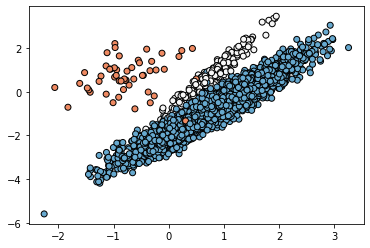

In [1]:
import seaborn as sns
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

import matplotlib.pyplot as plt
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
fig = plt.Figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c=colors, **kwarg_params)

### Synthetic Benchmark

In [2]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.datasets import make_classification


def label(df, class_sep, trans=LabelPropagation()):
    """Label a point cloud with the given class separation """
    X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                               n_redundant=0, n_repeated=0, n_classes=3,
                               n_clusters_per_class=1,
                               weights=[0.05, 0.10, 0.85],
                               class_sep=class_sep, random_state=0)
    
    X_l = X.shape[0]
    np.random.seed(42)
    unl_idx = np.random.randint(0, len(X), size=X_l - 500)
    l_idx = list(set(range(X_l)).difference(set(unl_idx)))
    X_unlabeled, X_labeled = X[unl_idx], X[l_idx]
    y_unlabeled, y_labeled = y[unl_idx], y[l_idx]
    
    trans = LabelPropagation()
    trans.fit(X_labeled, y_labeled)

    y_unlabeled_pred = trans.predict(X_unlabeled)
    
    r = (pd.DataFrame({'y': y_unlabeled, 'y_pred': y_unlabeled_pred}))
    
    return X_unlabeled, X_labeled, y_unlabeled, y_labeled, r

Text(0.5, 0.98, '$LabelPropagation$ Performance Benchmark, $Sep \\in [0.1, 0.5, 1, 2]$')

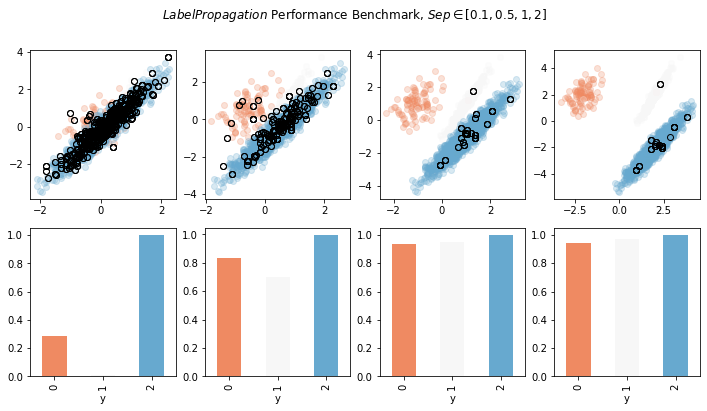

In [3]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.datasets import make_classification


def label(df, class_sep, trans=LabelPropagation()):
    """Label a point cloud with the given class separation """
    X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                               n_redundant=0, n_repeated=0, n_classes=3,
                               n_clusters_per_class=1,
                               weights=[0.05, 0.10, 0.85],
                               class_sep=class_sep, random_state=0)
    
    X_l = X.shape[0]
    np.random.seed(42)
    unl_idx = np.random.randint(0, len(X), size=X_l - 500)
    l_idx = list(set(range(X_l)).difference(set(unl_idx)))
    X_unlabeled, X_labeled = X[unl_idx], X[l_idx]
    y_unlabeled, y_labeled = y[unl_idx], y[l_idx]
    
    trans = LabelPropagation()
    trans.fit(X_labeled, y_labeled)

    y_unlabeled_pred = trans.predict(X_unlabeled)
    
    r = (pd.DataFrame({'y': y_unlabeled, 'y_pred': y_unlabeled_pred}))
    
    return X_unlabeled, X_labeled, y_unlabeled, y_labeled, r

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cmap = {0: '#ef8a62',1: '#f7f7f7', 2: '#67a9cf'}
fig, axarr = plt.subplots(2, 4, figsize=(12, 6))

for plot_n, sep in enumerate([0.1, 0.5, 1, 2]):
    X_unlabeled, X_labeled, y_unlabeled, y_labeled, r = label(X, sep, trans=LabelPropagation())

    for classnum, color in cmap.items():
        k_idx_labeled = np.where(y_labeled == classnum)[0]
        X_v, y_v = X_labeled[k_idx_labeled], y_labeled[k_idx_labeled]
        axarr[0][plot_n].plot(X_v[:, 0], X_v[:, 1], marker='o', linewidth=0, alpha=0.25, c=color)
        
        k_idx_unlabeled_misclassified = np.where(r.query("y == @classnum & y != y_pred").values)[0]
        X_v, y_v = X_unlabeled[k_idx_unlabeled_misclassified], y_unlabeled[k_idx_unlabeled_misclassified]
        axarr[0][plot_n].plot(X_v[:, 0], X_v[:, 1], marker='o', 
                              markeredgewidth=1, markeredgecolor='black', linewidth=0, c='None', zorder=10)
        
    result = r.rename_axis(None).groupby('y').apply(lambda df: (df.y == df.y_pred).sum() / len(df))
    result.plot.bar(color=cmap.values(), ax=axarr[1][plot_n])
        
plt.suptitle("$LabelPropagation$ Performance Benchmark, $Sep \in [0.1, 0.5, 1, 2]$")

In the plots above I show class clusters with different levels of class separation, from almost none to almost complete. In this plot I show, for each of these levels, the performance of the LabelPropagation labeling algorithm: how well it performs on each class, and also which points exactly it gets wrong. Note that the presence of a handful of wayward points in the dominant clusters (blue and white) is actually a suprising artifact of make_classification.

As you can see, class differenciability is extremely important for successful labeling. This hopefully isn't surprising. Respective to using standard machine learning algorithms for this task, the one adaptation that these semi-supervised algorithms make is that they generalize better when there are very few labels.

Text(0.5, 0.98, '$LabelSpreading$ Performance Benchmark, $Sep \\in [0.1, 0.5, 1, 2]$')

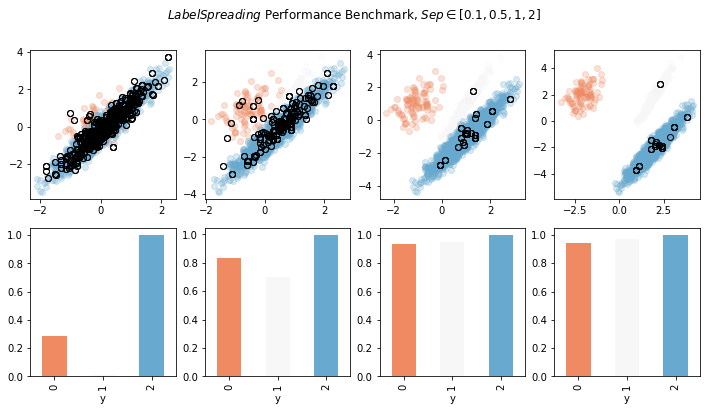

In [4]:
from sklearn.semi_supervised import LabelSpreading

fig, axarr = plt.subplots(2, 4, figsize=(12, 6))

for plot_n, sep in enumerate([0.1, 0.5, 1, 2]):
    X_unlabeled, X_labeled, y_unlabeled, y_labeled, r = label(X, sep, trans=LabelSpreading())

    for classnum, color in cmap.items():
        k_idx_labeled = np.where(y_labeled == classnum)[0]
        X_v, y_v = X_labeled[k_idx_labeled], y_labeled[k_idx_labeled]
        axarr[0][plot_n].plot(X_v[:, 0], X_v[:, 1], marker='o', linewidth=0, alpha=0.25, c=color)
        
        k_idx_unlabeled_misclassified = np.where(r.query("y == @classnum & y != y_pred").values)[0]
        X_v, y_v = X_unlabeled[k_idx_unlabeled_misclassified], y_unlabeled[k_idx_unlabeled_misclassified]
        axarr[0][plot_n].plot(X_v[:, 0], X_v[:, 1], marker='o', 
                              markeredgewidth=1, markeredgecolor='black', linewidth=0, c='None', zorder=10)
        
        result = r.rename_axis(None).groupby('y').apply(lambda df: (df.y == df.y_pred).sum() / len(df))
        result.plot.bar(color=cmap.values(), ax=axarr[1][plot_n])
        
plt.suptitle("$LabelSpreading$ Performance Benchmark, $Sep \in [0.1, 0.5, 1, 2]$")

Here I demonstrate the LabelSpreading algorithm. As you can see, the performance of this algorithm on this test dataset is almost synonymous with that of LabelPropagation (and again, note that the misclassified points in 3 and 4 are mostly make_classification artifacts!).

Note that the algorithms provide regularization and kernel hyperparameters that I will not tune or explore here. For this synthetic dataset it will not make much of a difference, but the higher the level of noise in the dataset the more important parameter tuning becomes.

## Application Benchmark
 tried applying this algorithm to a real dataset, the Open Powerlifting Database, to assign Division information to fields lacking it. However, this turned out to be foolish, as the class clusters were not sufficiently well-distributed. The accuracy was nearly 0.

In [5]:
import pandas as pd
df = pd.read_csv("./openpowerlifting.csv")

# import missingno as msno
# msno.matrix(df.sample(1000))

import numpy as np
np.random.seed(42)

cols = ['Sex', 'Equipment', 'Age', 'BodyweightKg', 'TotalKg', 'Wilks', 'Division']

df_nonempty = (df
   .dropna(subset=['Division'])
   .drop(['MeetID', 'Name', 'Place', 'WeightClassKg'], axis='columns')
   .pipe(lambda df: df.assign(
         Sex=df.Sex.astype('category').cat.codes,
         Division=df.Division.astype('category').cat.codes,
         Equipment=df.Equipment.astype('category').cat.codes
   ))
   .pipe(lambda df: df[df.Division.isin(df.Division.value_counts().head(10).index.values)])
   .loc[:, cols]
   .dropna()
   .reset_index(drop=True)               
)
unl_idx = np.random.randint(0, len(df_nonempty), size=len(df_nonempty) - 500)
l_idx = list(set(range(len(df_nonempty))).difference(set(unl_idx)))

cols = [c for c in cols if c != 'Division']

X_unlabeled, X_labeled = df_nonempty.loc[unl_idx, cols].head(5000), df_nonempty.loc[l_idx, cols].head(5000)
y_unlabeled, y_labeled = df_nonempty.loc[unl_idx, 'Division'].head(5000), df_nonempty.loc[l_idx, 'Division'].head(5000)

In [6]:
from sklearn.semi_supervised import LabelPropagation

trans = LabelPropagation()
trans.fit(X_labeled, y_labeled)

np.random.seed(42)
y_unlabeled_pred = trans.predict(X_unlabeled)

print("Performance on division imputation: {0}% Accuracy".format((y_unlabeled_pred == y_unlabeled)\
                                                                 .pipe(lambda df: df.sum() / len(df))))

Performance on division imputation: 0.283% Accuracy


/Users/salvadorgarcialopez/opt/anaconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
